In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold

In [2]:
DATA_DIR = "/opt/ml/detection/dataset"

# Split data

- reference
https://www.kaggle.com/backtracking/smart-data-split-train-eval-for-object-detection/notebook

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2013)
df_folds = annotations_df[['image_id']].copy()

In [32]:
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = annotations_df.groupby('image_id')['category_id'].nunique()
# df_folds.loc[:, 'stratify_group'] = np.char.add(
#     df_folds['object_count'].values.astype(str),
#     df_folds['bbox_count'].apply(lambda x: f'_{x // 10}').values.astype(str)
# )

In [33]:
# df_folds = pd.merge(df, df_folds, on='image_id')

In [34]:
df_folds

,bbox_count,object_count
image_id,,
0,1,1
1,8,5
2,1,1
3,2,2
4,6,2
...,...,...
4878,1,1
4879,4,3
4880,1,1


In [35]:
df_folds.loc[:, 'fold'] = 0
# for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['category_id'], groups=df_folds['object_count'])):
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['object_count'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [36]:
df = annotations_df.copy()
df_folds

,bbox_count,object_count,fold
image_id,,,
0,1,1,1
1,8,5,2
2,1,1,1
3,2,2,0
4,6,2,0
...,...,...,...
4878,1,1,4
4879,4,3,1
4880,1,1,3


In [22]:
df_valid

,image_id,category_id_x,area_x,bbox_x,iscrowd_x,id_x,x_min_x,x_center_x,x_max_x,y_min_x,...,x_max_y,y_min_y,y_center_y,y_max_y,w_y,h_y,bbox_count,object_count,stratify_group,fold
0,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,28.80,57.6,407.4,...,57.6,407.4,497.70,588.0,57.6,180.6,8,5,5_0,0
1,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,72.30,144.6,455.6,...,57.6,407.4,497.70,588.0,57.6,180.6,8,5,5_0,0
2,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,859.45,996.6,313.4,...,57.6,407.4,497.70,588.0,57.6,180.6,8,5,5_0,0
3,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,470.05,586.9,671.0,...,57.6,407.4,497.70,588.0,57.6,180.6,8,5,5_0,0
4,1,5,188324.40,"[3.7, 448.5, 778.2, 242.0]",0,5,3.7,392.80,781.9,448.5,...,57.6,407.4,497.70,588.0,57.6,180.6,8,5,5_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62319,4876,2,140583.67,"[300.2, 457.1, 422.3, 332.9]",0,23126,300.2,511.35,722.5,457.1,...,465.8,722.3,873.00,1023.7,175.0,301.4,3,2,2_0,0
62320,4879,5,43217.02,"[160.5, 441.9, 186.2, 232.1]",0,23130,160.5,253.60,346.7,441.9,...,346.7,441.9,557.95,674.0,186.2,232.1,4,3,3_0,0
62321,4879,0,10630.44,"[660.7, 615.6, 91.8, 115.8]",0,23131,660.7,706.60,752.5,615.6,...,346.7,441.9,557.95,674.0,186.2,232.1,4,3,3_0,0
62322,4879,7,15200.76,"[476.1, 640.5, 224.2, 67.8]",0,23132,476.1,588.20,700.3,640.5,...,346.7,441.9,557.95,674.0,186.2,232.1,4,3,3_0,0


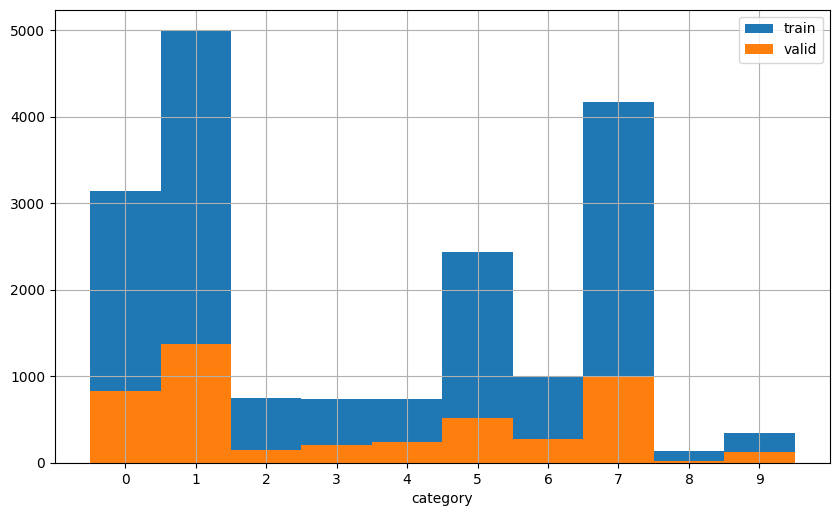

In [37]:
df_folds.reset_index(inplace=True)

df_valid = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')
df_train = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')
# df_valid = df_folds[df_folds['fold'] == 0]
# df_train = df_folds[df_folds['fold'] != 0]

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100)
df_train['category_id'].hist(ax=ax, bins=np.arange(-1, 10)+0.5, label='train')
df_valid['category_id'].hist(ax=ax, bins=np.arange(-1, 10)+0.5, label='valid')
ax.set_xticks([_ for _ in range(10)])
ax.set_xlabel('category')
ax.legend()

In [159]:
# df_valid['category_id'].value_counts(normalize=True)
df_valid['category_id'].value_counts()

1    1250
7     974
0     779
5     650
6     298
4     202
2     189
3     164
9      81
8      55
Name: category_id, dtype: int64

In [160]:
# df_train['category_id'].value_counts(normalize=True)
df_train['category_id'].value_counts()

1    5102
7    4204
0    3187
5    2293
6     965
4     780
3     772
2     708
9     387
8     104
Name: category_id, dtype: int64

In [155]:
df_train.to_csv('annotations_train.csv', index=False)
df_valid.to_csv('annotations_valid.csv', index=False)

In [139]:
category_per_image_dict = df_folds['object_count'].value_counts().to_dict()

In [148]:
category_per_image_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

Text(0.5, 0, 'Number of categories')

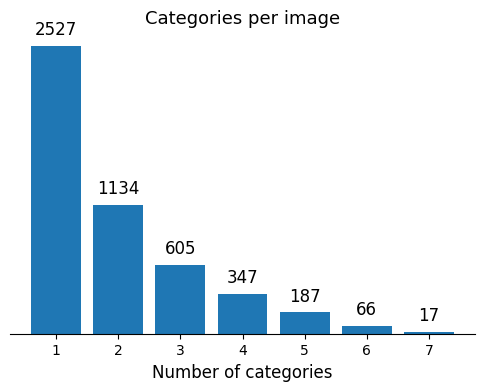

In [158]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.bar(x=[_ for _ in range(1, 8)], height=category_per_image_dict.values())
for key in category_per_image_dict:
    ax.text(key, category_per_image_dict[key]+100, category_per_image_dict[key], ha='center', fontdict={'size': 12})
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Categories per image', fontdict={'size': 13})
ax.set_xlabel('Number of categories', fontdict={'size': 12})

(100.0, 1500000.0)

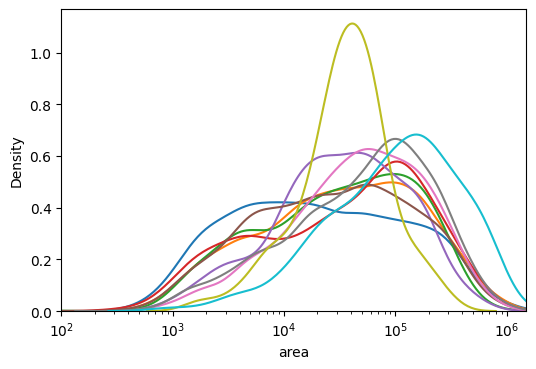

In [13]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 0, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 1, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 2, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 3, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 4, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 5, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 6, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 7, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 8, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 9, 'area'], ax=ax, log_scale=True)
ax.set_xlim(1e2, 1.5e6)

# Make JSON format

In [3]:
file_name = f"{DATA_DIR}/train.json"

class ReadCOCOjson:
    def __init__(self, json_file: str) -> None:
        with open(json_file, 'r') as f:
            self.json_dict = json.load(f) 
        print(f"json_key: {self.json_dict.keys()}")
        self.images_df = pd.DataFrame(self.json_dict['images'])
        self.annotations_df = pd.DataFrame(self.json_dict['annotations'])
    
    def get_extra_coord(self):
        bbox_array = np.array(self.annotations_df['bbox'].to_list())
        # x
        self.annotations_df['x_min'] = bbox_array[:, 0]
        self.annotations_df['x_center'] = bbox_array[:, 0] + bbox_array[:, 2]/2
        self.annotations_df['x_max'] = bbox_array[:, 0] + bbox_array[:, 2]
        # y
        self.annotations_df['y_min'] = bbox_array[:, 1]
        self.annotations_df['y_center'] = bbox_array[:, 1] + bbox_array[:, 3]/2
        self.annotations_df['y_max'] = bbox_array[:, 1] + bbox_array[:, 3]
        # w
        self.annotations_df['w'] = bbox_array[:, 2]
        # h
        self.annotations_df['h'] = bbox_array[:, 3]

coco_json = ReadCOCOjson(file_name)

json_key: dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


In [8]:
coco_json.get_extra_coord()
coco_json.annotations_df

,image_id,category_id,area,bbox,iscrowd,id,x_min,x_center,x_max,y_min,y_center,y_max,w,h
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,471.50,745.4,193.7,428.55,663.4,547.8,469.7
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,28.80,57.6,407.4,497.70,588.0,57.6,180.6
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,72.30,144.6,455.6,546.40,637.2,144.6,181.6
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,859.45,996.6,313.4,439.35,565.3,274.3,251.9
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,470.05,586.9,671.0,722.70,774.4,233.7,103.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139,0.0,472.05,944.1,116.2,523.25,930.3,944.1,814.1
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140,302.1,434.70,567.3,439.3,547.35,655.4,265.2,216.1
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141,511.3,540.65,570.0,451.1,466.20,481.3,58.7,30.2
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142,255.0,390.85,526.7,421.4,518.95,616.5,271.7,195.1


In [9]:
train_df = pd.read_csv(f"{DATA_DIR}/annotations_train.csv", converters={'bbox': eval})
valid_df = pd.read_csv(f"{DATA_DIR}/annotations_valid.csv", converters={'bbox': eval})

In [10]:
with open(f'{DATA_DIR}/train.json', 'r') as f:
    origin_json = json.load(f)

origin_images_df =  pd.DataFrame(origin_json['images'])

dummy_json = origin_json.copy()
dummy_json['images'] = []
dummy_json['annotations'] = []

train_json = dummy_json.copy()
valid_json = dummy_json.copy()

# train
## annotations
json_result = train_df.loc[:, ['image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id']].to_json(orient="table", index=False)
parsed = json.loads(json_result)
train_json['annotations'] = parsed['data']
## origin_json images
json_result = origin_images_df.loc[train_df['image_id'].unique()].to_json(orient="table", index=False)
parsed = json.loads(json_result)
train_json['images'] = parsed['data']

# valid
## annotations
json_result = valid_df.loc[:, ['image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id']].to_json(orient="table", index=False)
parsed = json.loads(json_result)
valid_json['annotations'] = parsed['data']
## origin_json images
json_result = origin_images_df.loc[valid_df['image_id'].unique()].to_json(orient="table", index=False)
parsed = json.loads(json_result)
valid_json['images'] = parsed['data']

# Save json file format
# with open('stratified_train.json', 'w') as f:
#     json.dump(train_json, f, indent=2)
# with open('stratified_valid.json', 'w') as f:
#     json.dump(valid_json, f, indent=2)

In [15]:
parsed

{'schema': {'fields': [{'name': 'width', 'type': 'integer'},
   {'name': 'height', 'type': 'integer'},
   {'name': 'file_name', 'type': 'string'},
   {'name': 'license', 'type': 'integer'},
   {'name': 'flickr_url', 'type': 'string'},
   {'name': 'coco_url', 'type': 'string'},
   {'name': 'date_captured', 'type': 'string'},
   {'name': 'id', 'type': 'integer'}],
  'pandas_version': '0.20.0'},
 'data': [{'width': 1024,
   'height': 1024,
   'file_name': 'train/0015.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2021-03-31 15:55:12',
   'id': 15},
  {'width': 1024,
   'height': 1024,
   'file_name': 'train/0016.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2020-12-29 15:27:59',
   'id': 16},
  {'width': 1024,
   'height': 1024,
   'file_name': 'train/0017.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2021-04-27 10:34:39',
   'id': 17},
  {'width': 1024,
   'height'

In [11]:
dummy_json

{'info': {'year': 2021,
  'version': '1.0',
  'description': 'Recycle Trash',
  'contributor': 'Upstage',
  'url': None,
  'date_created': '2021-02-02 01:10:00'},
 'licenses': [{'id': 0,
   'name': 'CC BY 4.0',
   'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}],
 'images': [],
 'categories': [{'id': 0,
   'name': 'General trash',
   'supercategory': 'General trash'},
  {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'},
  {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
  {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'},
  {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'},
  {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'},
  {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
  {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
  {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'},
  {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}],
 'annotations': []}